# 전처리 

## module

In [1]:
import pandas as pd
import numpy as np
import os
import scipy
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

## Load Data

In [2]:
data_path = "../data"
feature_path = "feature_v1.csv"

In [3]:
df = pd.read_csv(os.path.join(data_path, feature_path))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2919 non-null   int64  
 1   ms_subclass        2919 non-null   int64  
 2   ms_zoning          2919 non-null   object 
 3   lot_frontage       2919 non-null   float64
 4   lot_area           2919 non-null   int64  
 5   street_access      2919 non-null   object 
 6   alley              198 non-null    object 
 7   lot_shape          2919 non-null   object 
 8   land_contour       2919 non-null   object 
 9   utilities          2919 non-null   object 
 10  lot_config         2919 non-null   object 
 11  land_slope         2919 non-null   object 
 12  neighborhood       2919 non-null   object 
 13  condition1         2919 non-null   object 
 14  condition2         2919 non-null   object 
 15  bldg_type          2919 non-null   object 
 16  house_style        2919 

In [4]:
train = df[df["sale_price"].isna() == False]

## Dictionary 및 Function


In [5]:
# central air
def y_n_classify(x):
    if x == "Y":
        return 1
    return 0

def is_exist_fence(x):
    if x == "None":
        return "None"
    return "Exist"

def is_func(x):
    if x == "Typ":
        return 0
    return 1

def is_pool(x):
    if x > 0:
        return 1
    return 0

# category data _ order
basic_qual_cond = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1,
    0 : 0
}

dict_bsmt_exposure = {
    "Gd" : 4,
    "Av" : 3,
    "Mn" : 2,
    "No" : 1,
    0 : 0
}

dict_bsmt_type = {
    "GLQ": 6,
    "ALQ": 5,
    "BLQ": 4,
    "Rec": 3,
    "LwQ": 2,
    "Unf": 1,
    0 : 0
}

dict_electrical = {
    "SBrkr" : 5,
    "FuseA" : 4,
    "FuseF" : 3,
    "Mix" : 2,
    "FuseP" : 1
}

dict_functional = {
    "Typ" : 3,
    "Min1" : 2,
    "Min2" : 2,
    "Mod" : 2,
    "Maj1" : 1,
    "Maj2" : 1,
    "Sev" : 1,
    "Sal" : 1,
}

dict_garage_finish = {
    "Fin" : 3,
    "RFn" : 2,
    "Unf" : 1,
    "None" : 0
}

dict_fence_qual = {
    "GdPrv" : 2,
    "MnPrv" : 1,
    "GdWo" : 2,
    "MnWw" : 1,
    0 : 0
}

dict_overall_cond = {
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9 : 3,
    10 : 3
}

garage_qual_cond = {
    "Ex" : 3,
    "Gd" : 2,
    "TA" : 1,
    "Fa" : 0,
    "Po" : 0,
    "None" : 0
}



In [6]:
# columns 분류

# category - 명목형
category1 = ["ms_subclass","ms_zoning","street_access","lot_shape", "alley",
             "land_contour","utilities","lot_config","land_slope","neighborhood",
             "condition1","condition2","bldg_type","house_style","roof_style",
             "roof_matl","exterior_1st","exterior_2nd","mas_vnr_type","foundation",
             "heating","central_air","garage_type","paved_drive","misc_feature",
             "sale_type","sale_cond", "is_fence", "is_functional", "is_pool"]

# category - 순서형(점수)
category2 = ["overall_qual","overall_cond","exter_qual","exter_cond","bsmt_qual",
             "bsmt_cond","bsmt_exposure","bsmt_fin_type1","bsmt_fin_type2",
             "heating_qc","electrical","kitchen_qual","fireplace_qual",
             "garage_finish","garage_qual","garage_cond"]

# integer - 이산형 (개수)
integer1 = ["bsmt_full_bath","bsmt_half_bath","full_bath","half_bath","bedroom",
            "kitchen","tot_rms_abv_grd","garage_cars","fireplaces"]

# integer - 연속형 (거리, 면적)
integer2 = ["lot_frontage","lot_area", "mas_vnr_area", "bsmt_fin_sf1", "bsmt_fin_sf2",
            "bsmt_un_sf", "total_bsmt_sf","1st_flr_sf","2nd_flr_sf","low_qual_fin_sf",
            "gr_liv_area","garage_area","wood_deck_sf","open_porch_sf",
            "enclosed_porch_sf","3ssn_porch_sf","screen_porch_sf"]

# interger - 연속형 - 가치
integer3 = ["misc_val"]

# 시계열 데이터 년도 혹은 달
time_data = ["year_built", "year_remod_add", "garage_yr_built", "mo_sold", "yr_sold", "year_built_v1"]

# 차고 관련 컬럼
garage_cols = ["garage_type","garage_finish","garage_qual","garage_cond","garage_cars","garage_yr_built", "garage_area"]

# 지하실 관련 컬럼
bsmt_cols = ["bsmt_qual","bsmt_cond","bsmt_exposure","bsmt_fin_type1","bsmt_fin_type2","bsmt_full_bath","bsmt_half_bath", "bsmt_fin_sf1", "bsmt_fin_sf2","bsmt_un_sf", "total_bsmt_sf"]


all_columns = category1 + category2 + integer1 + integer2 + integer3 + time_data

set(df.columns) - set(all_columns)

{'id', 'sale_price'}

In [7]:
set(all_columns) - set(df.columns) 

set()

## Preprocessing

### 순서형 데이터 처리

In [8]:
category2 = ["overall_qual","overall_cond","exter_qual","exter_cond","bsmt_qual",
             "bsmt_cond","bsmt_exposure","bsmt_fin_type1","bsmt_fin_type2",
             "heating_qc","electrical","kitchen_qual","fireplace_qual",
             "garage_finish","garage_qual","garage_cond", "is_fence", "is_functional", "is_pool"]

#### overall qual

In [9]:
train["overall_qual"].value_counts()

overall_qual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64

<Axes: xlabel='overall_qual', ylabel='sale_price'>

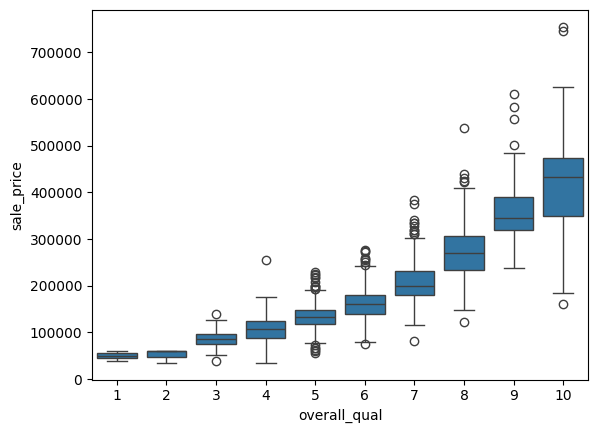

In [10]:
sns.boxplot(data=train, x="overall_qual", y="sale_price")

#### overall cond

In [11]:
train["overall_cond"].value_counts()

overall_cond
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: count, dtype: int64

<Axes: xlabel='overall_cond', ylabel='sale_price'>

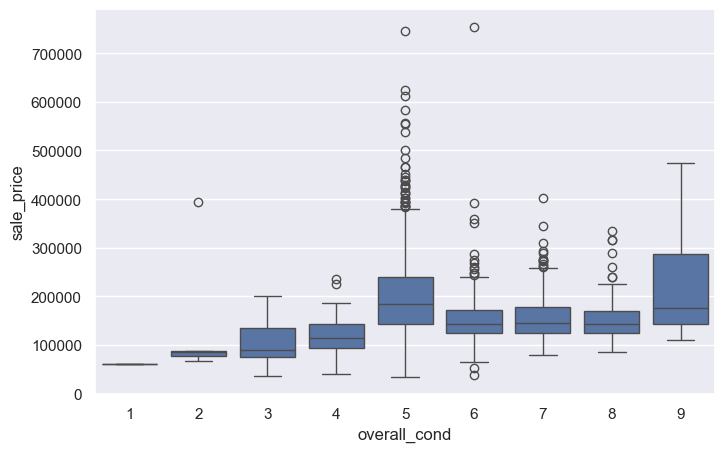

In [12]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="overall_cond", y="sale_price")

In [13]:
dict_overall_cond = {
    1.: 1,
    2.: 1,
    3.: 1,
    4.: 1,
    5.: 2,
    6.: 3,
    7.: 3,
    8.: 3,
    9. : 3,
    10. : 3
}

In [14]:
temp = train[["overall_cond", "sale_price", "neighborhood"]]

temp["overall_cond"] = temp["overall_cond"].map(dict_overall_cond)

temp["overall_cond"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\3452401627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["overall_cond"] = temp["overall_cond"].map(dict_overall_cond)


overall_cond
2    821
3    551
1     88
Name: count, dtype: int64

<Axes: xlabel='overall_cond', ylabel='sale_price'>

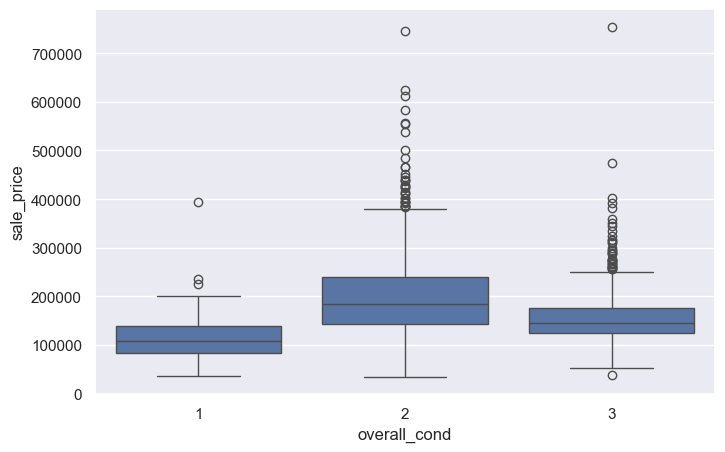

In [15]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=temp, x="overall_cond", y="sale_price")

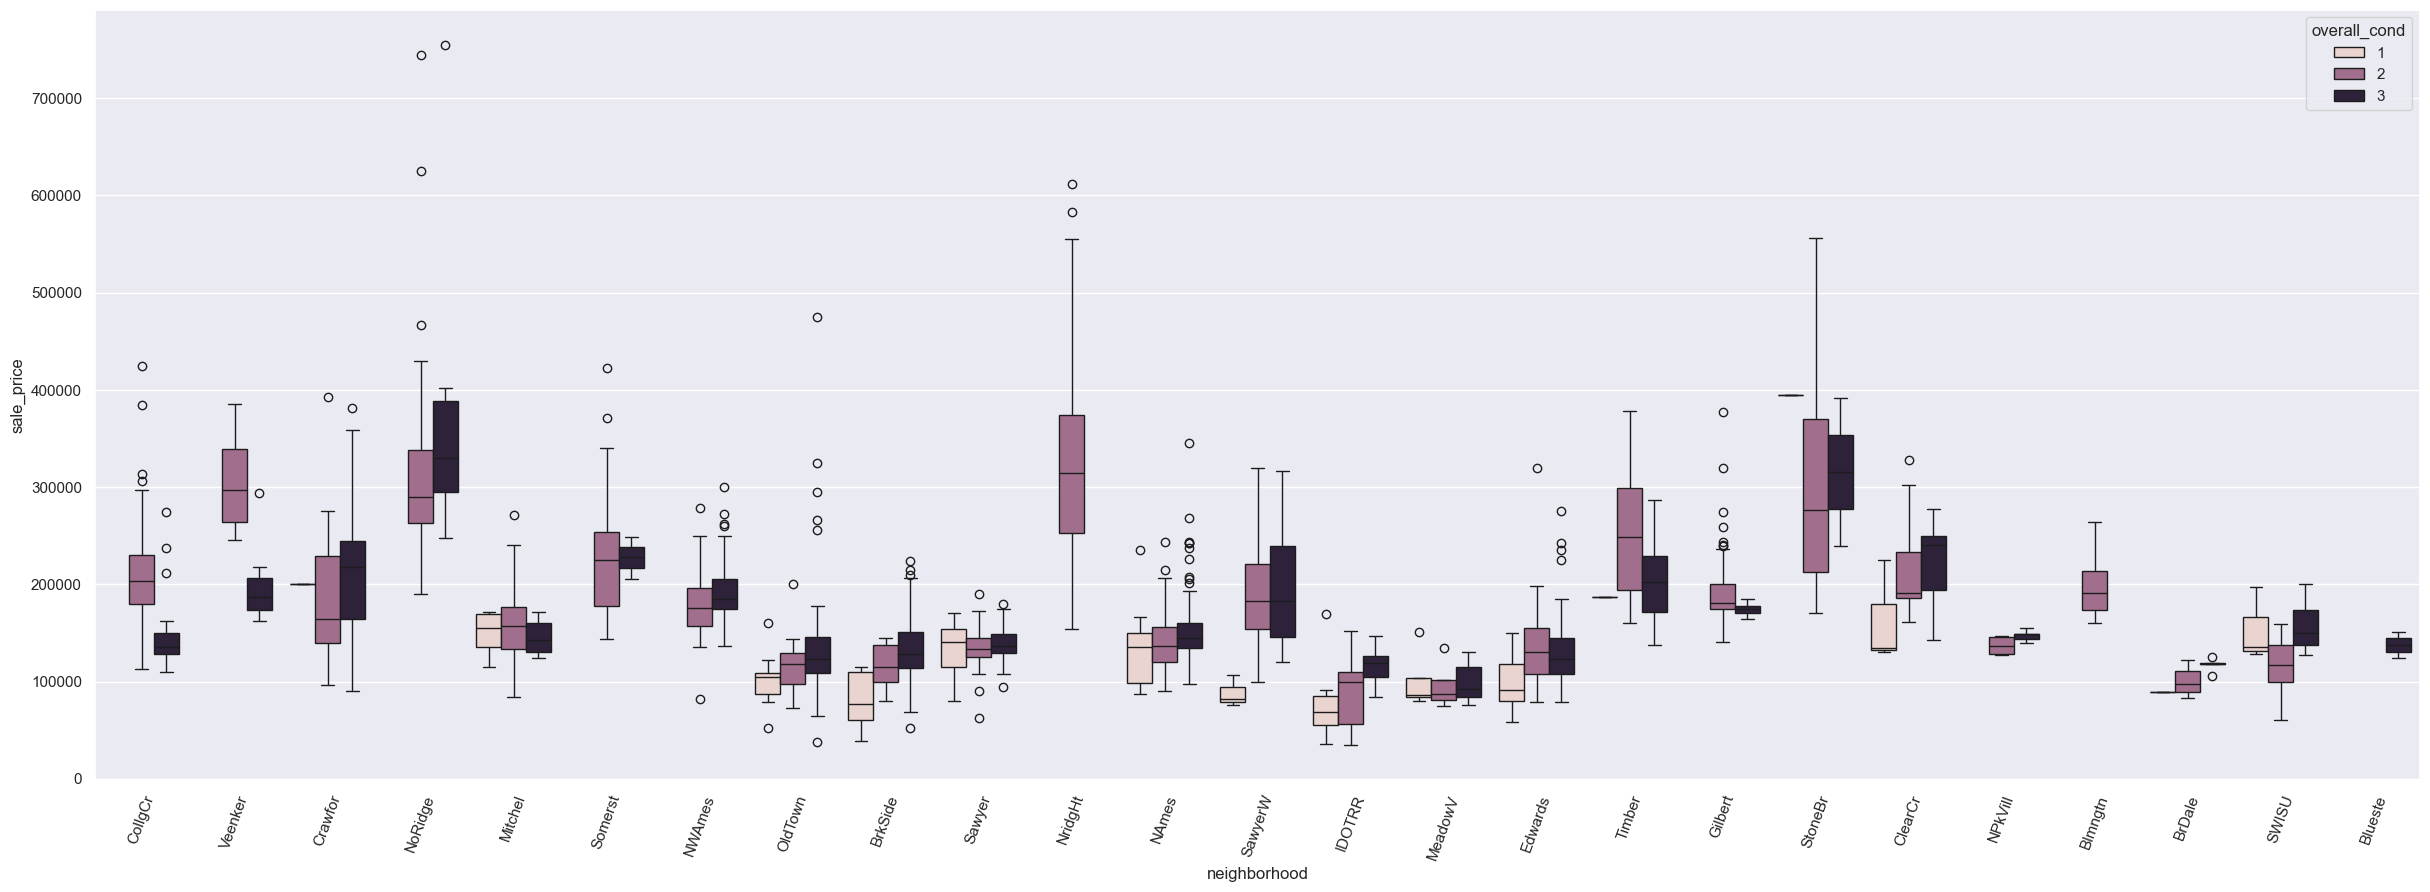

In [16]:
sns.set(rc={"figure.figsize": (30, 10)})

fig = sns.boxplot(data=temp, x="neighborhood", y="sale_price", hue="overall_cond")

fig.tick_params(axis='x', rotation=70)

fig

sns.set(rc={"figure.figsize": (8, 5)})


In [17]:
dict_overall_cond2= {
    1.: 0,
    2.: 0,
    3.: 0,
    4.: 0,
    5.: 1,
    6.: 1,
    7.: 1,
    8.: 1,
    9. : 1,
    10. : 1
}

In [18]:
temp = train[["overall_cond", "sale_price", "neighborhood"]]

temp["overall_cond"] = temp["overall_cond"].map(dict_overall_cond2)

temp["overall_cond"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\1211797640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["overall_cond"] = temp["overall_cond"].map(dict_overall_cond2)


overall_cond
1    1372
0      88
Name: count, dtype: int64

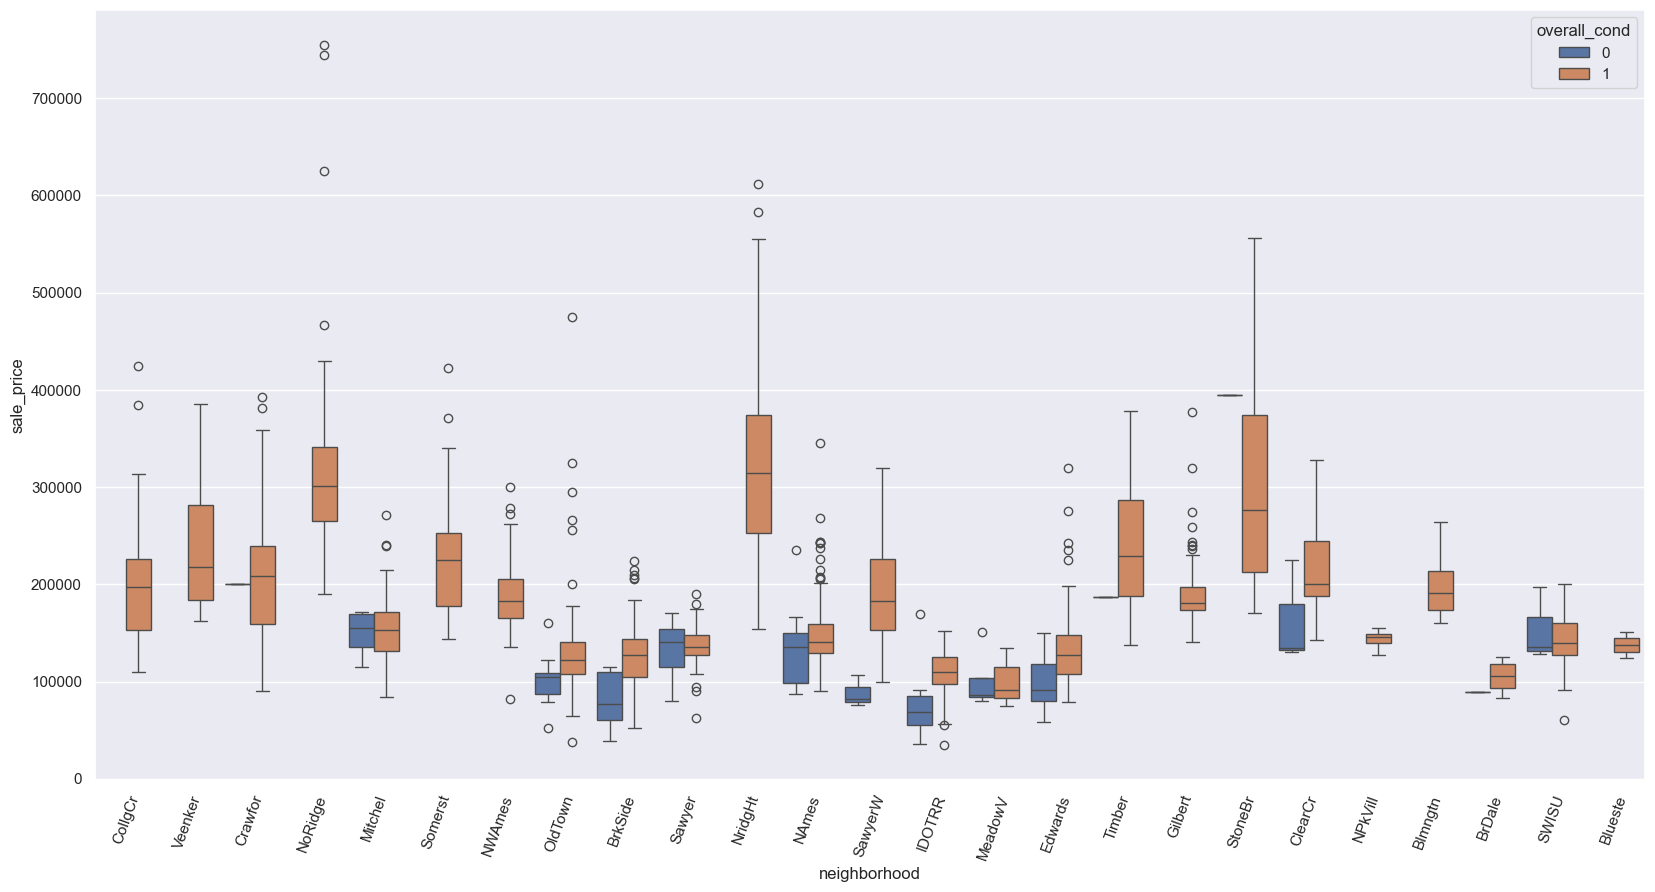

In [19]:
sns.set(rc={"figure.figsize": (20, 10)})

fig = sns.boxplot(data=temp, x="neighborhood", y="sale_price", hue="overall_cond")

fig.tick_params(axis='x', rotation=70)

fig

sns.set(rc={"figure.figsize": (8, 5)})


In [20]:
# df["overall_cond"] = df["overall_cond"].map(dict_overall_cond2)

#### exter_qual

In [21]:
df["exter_qual"].value_counts()

exter_qual
TA    1798
Gd     979
Ex     107
Fa      35
Name: count, dtype: int64

<Axes: xlabel='exter_qual', ylabel='sale_price'>

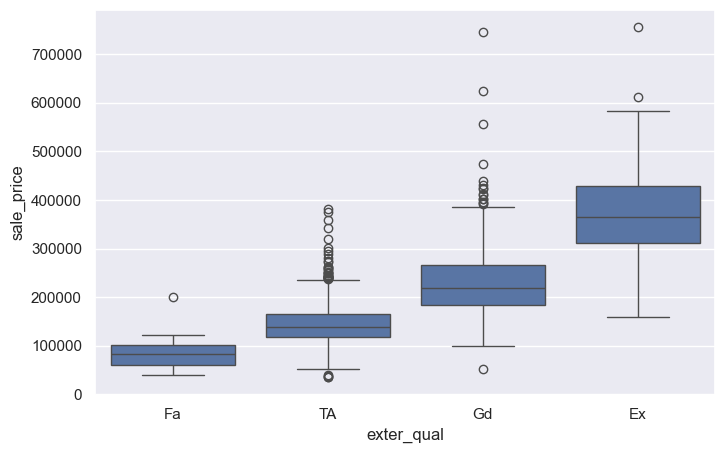

In [22]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="exter_qual", y="sale_price", order=["Fa", "TA", "Gd", "Ex"])

In [23]:
dict_exter_qual = {
    "Ex" : 4,
    "Gd" : 3,
    "TA" : 2,
    "Fa" : 1,
    "Po" : 1,
    0 : 0
}

df["exter_qual"] = df["exter_qual"].map(dict_exter_qual)

#### exter_cond

In [24]:
df["exter_cond"].value_counts()

exter_cond
TA    2538
Gd     299
Fa      67
Ex      12
Po       3
Name: count, dtype: int64

<Axes: xlabel='exter_cond', ylabel='sale_price'>

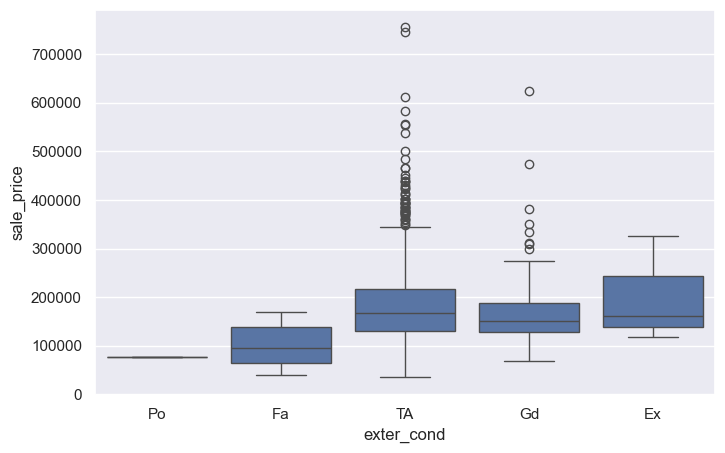

In [25]:
sns.set(rc={"figure.figsize": (8, 5)})


sns.boxplot(data=train, x="exter_cond", y="sale_price", order=["Po","Fa", "TA", "Gd", "Ex"])

In [26]:
dict_exter_cond = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1,
}

temp = train[["exter_cond", "sale_price", "neighborhood"]]

temp["exter_cond"] = temp["exter_cond"].map(dict_exter_cond)

temp["exter_cond"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\1204410077.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["exter_cond"] = temp["exter_cond"].map(dict_exter_cond)


exter_cond
3    1282
4     146
2      28
5       3
1       1
Name: count, dtype: int64

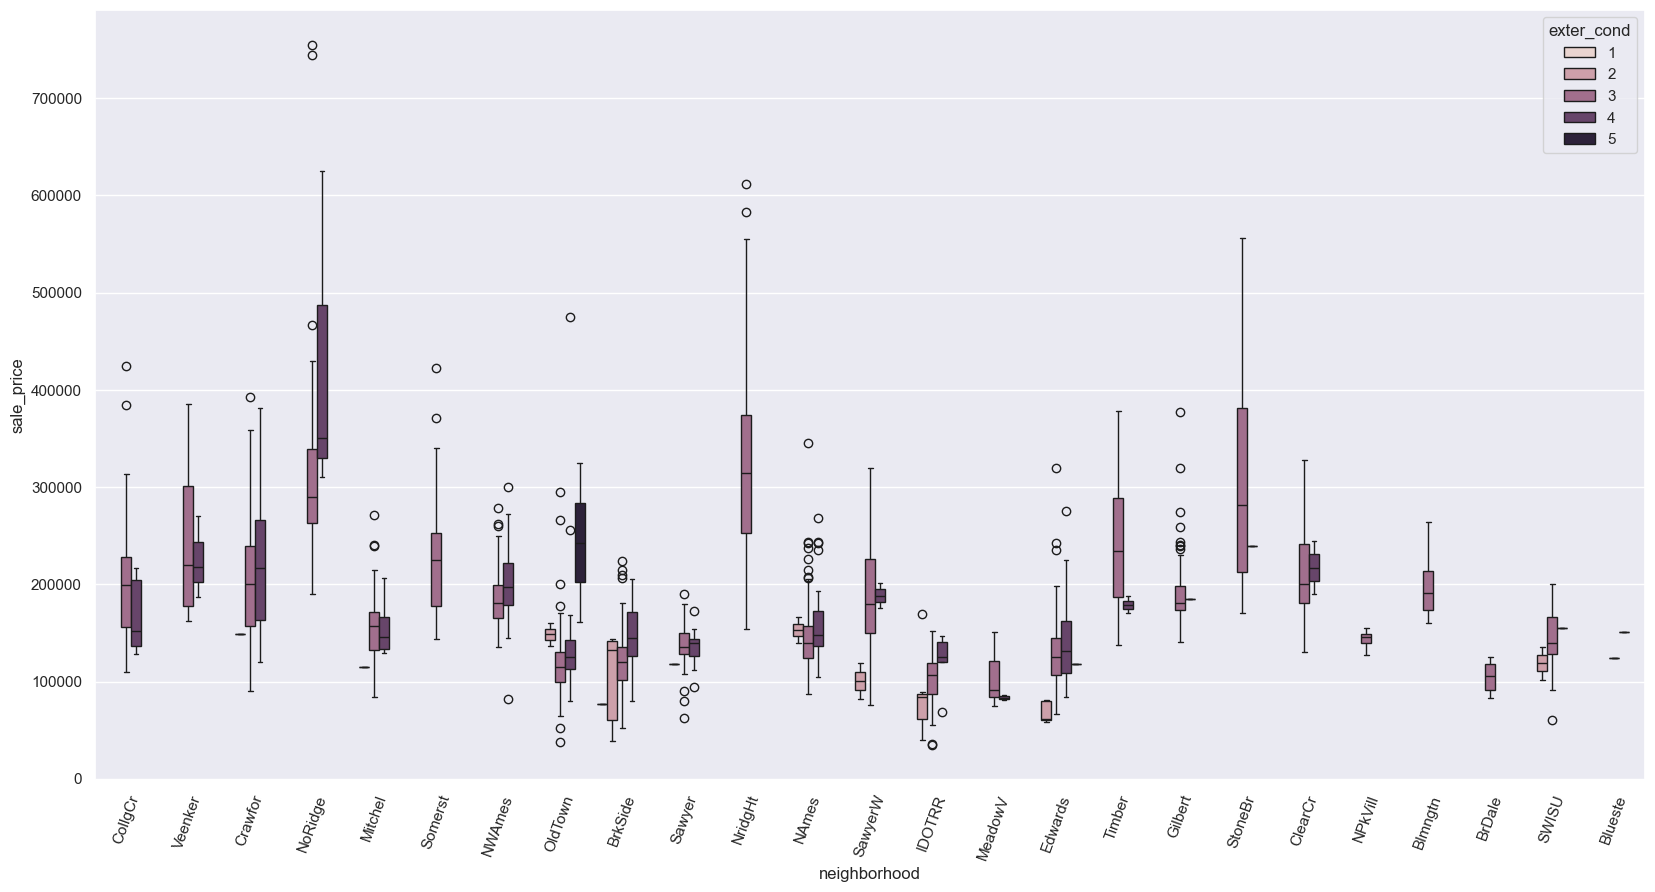

In [27]:
sns.set(rc={"figure.figsize": (20, 10)})

fig = sns.boxplot(data=temp, x="neighborhood", y="sale_price", hue="exter_cond")

fig.tick_params(axis='x', rotation=70)

fig

sns.set(rc={"figure.figsize": (8, 5)})


In [28]:
df["exter_cond"] = df["exter_cond"].map(dict_exter_cond)

#### other_basics

In [29]:
basic_ca2_cols = ["bsmt_qual","bsmt_cond", "heating_qc", "kitchen_qual",
                  "fireplace_qual", "garage_qual", "garage_cond"]

for col in basic_ca2_cols:
    print(f"[{col}] 결측치 개수 : {len(df[df[col].isna()])}")


[bsmt_qual] 결측치 개수 : 79
[bsmt_cond] 결측치 개수 : 79
[heating_qc] 결측치 개수 : 0
[kitchen_qual] 결측치 개수 : 0
[fireplace_qual] 결측치 개수 : 0
[garage_qual] 결측치 개수 : 158
[garage_cond] 결측치 개수 : 158


In [30]:
for col in ["heating_qc", "kitchen_qual"]:
    df[col] = df[col].apply(lambda x:basic_qual_cond[x])
    df[col] = df[col].astype("int8")

In [31]:
df["fireplace_qual"] = df["fireplace_qual"].map(basic_qual_cond).astype("int8")

In [32]:
train["bsmt_cond"].fillna("None", inplace=True)
train["bsmt_qual"].fillna("None", inplace=True)


C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\3224536597.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["bsmt_cond"].fillna("None", inplace=True)
C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\3224536597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["bsmt_cond"].fillna("None", inplace=True)
C:\Users\kkj98\AppData\

In [33]:
train["bsmt_qual"].value_counts()

bsmt_qual
TA      649
Gd      618
Ex      121
None     37
Fa       35
Name: count, dtype: int64

<Axes: xlabel='bsmt_qual', ylabel='sale_price'>

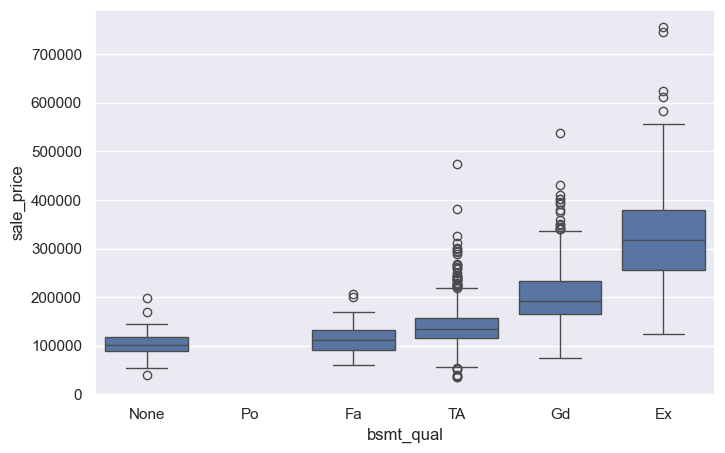

In [34]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="bsmt_qual", y="sale_price", order=["None","Po","Fa","TA","Gd","Ex"])

In [35]:
dict_bsmt_qual = {
    "None" : 0,
    "Po" : 0,
    "Fa" : 0,
    "TA" : 1,
    "Gd" : 2,
    "Ex" : 3
}

df["bsmt_qual"] = df["bsmt_qual"].fillna("None")

df["bsmt_qual"] = df["bsmt_qual"].map(dict_bsmt_qual).astype("int8")


In [36]:
train["bsmt_cond"].value_counts()

bsmt_cond
TA      1311
Gd        65
Fa        45
None      37
Po         2
Name: count, dtype: int64

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\3244434160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["bsmt_cond"].fillna("None", inplace=True)


<Axes: xlabel='bsmt_cond', ylabel='sale_price'>

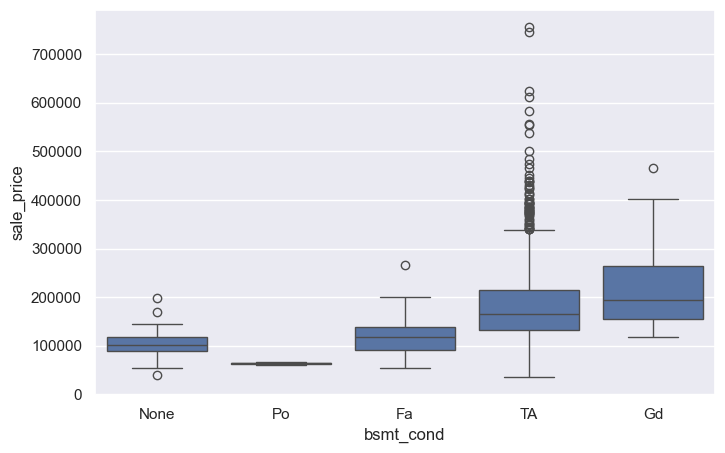

In [37]:
train["bsmt_cond"].fillna("None", inplace=True)
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="bsmt_cond", y="sale_price", order=["None","Po","Fa","TA","Gd"])

In [38]:
dict_bsmt_cond = {
    "None" : 0,
    "Po" : 0,
    "Fa" : 1,
    "TA" : 2,
    "Gd" : 3,
    "Ex" : 4
}

df["bsmt_cond"] = df["bsmt_cond"].fillna("None")

df["bsmt_cond"] = df["bsmt_cond"].map(dict_bsmt_cond).astype("int8")
 

#### bsmt_type1, type2

In [39]:
df["bsmt_fin_type1"] = df["bsmt_fin_type1"].fillna("None")
df["bsmt_fin_type2"] = df["bsmt_fin_type2"].fillna("None")


In [40]:
dict_bsmt_type = {
    "GLQ": 6,
    "ALQ": 5,
    "BLQ": 4,
    "Rec": 3,
    "LwQ": 2,
    "Unf": 1,
    "None" : 0
}

In [41]:
df["bsmt_fin_type1"].value_counts()

bsmt_fin_type1
Unf     851
GLQ     849
ALQ     429
Rec     288
BLQ     269
LwQ     154
None     79
Name: count, dtype: int64

In [42]:
df["bsmt_fin_type"] = df["bsmt_fin_type1"].map(dict_bsmt_type) + df["bsmt_fin_type2"].map(dict_bsmt_type)

df["bsmt_fin_type"] = df["bsmt_fin_type"] // 2 

In [43]:
# bsmttype 1, 2 제거

df.drop(columns = ["bsmt_fin_type1", "bsmt_fin_type2"], inplace=True)

#### eletrical

In [44]:
df["electrical"].value_counts()

electrical
SBrkr    2672
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: count, dtype: int64

<Axes: xlabel='electrical', ylabel='sale_price'>

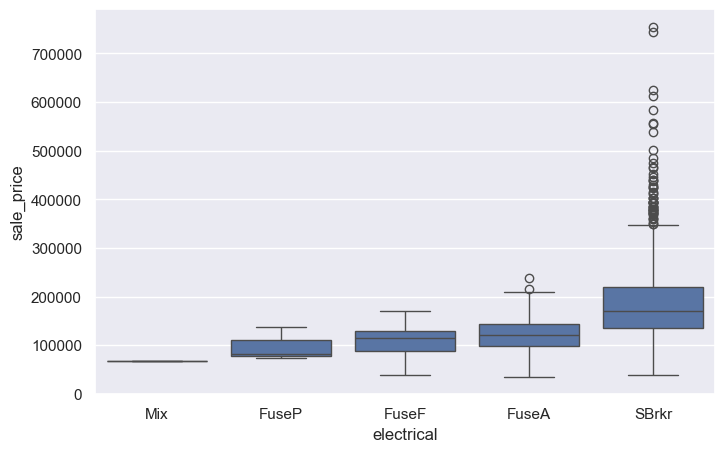

In [45]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="electrical", y="sale_price", order=["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"])

In [46]:
dict_electrical = {
    "SBrkr" : 1,
    "FuseA" : 0,
    "FuseF" : 0,
    "Mix" : 0,
    "FuseP" : 0
}

df["electrical"] = df["electrical"].map(dict_electrical).astype("int8")


#### bsmt_exposure

In [47]:
train["bsmt_exposure"] = train["bsmt_exposure"].fillna("None")

train["bsmt_exposure"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\497966992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["bsmt_exposure"] = train["bsmt_exposure"].fillna("None")


bsmt_exposure
No      954
Av      221
Gd      134
Mn      114
None     37
Name: count, dtype: int64

<Axes: xlabel='bsmt_exposure', ylabel='sale_price'>

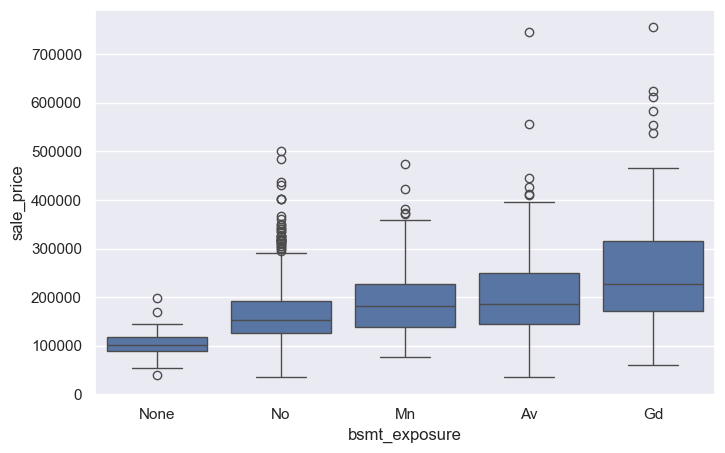

In [48]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="bsmt_exposure", y="sale_price", order=["None", "No", "Mn", "Av", "Gd"])

In [49]:
dict_exposure = {
    "Gd" : 4,
    "Av" : 3,
    "Mn" : 2,
    "No" : 1,
    "None" : 0
}

df["bsmt_exposure"] = df["bsmt_exposure"].fillna("None")

df["bsmt_exposure"] = df["bsmt_exposure"].map(dict_exposure).astype("int8")

#### garage_finish

In [50]:
df["garage_finish"] = df["garage_finish"].fillna("None")

train["garage_finish"] = train["garage_finish"].fillna("None")
df["garage_finish"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\2704746817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["garage_finish"] = train["garage_finish"].fillna("None")


garage_finish
Unf     1231
RFn      811
Fin      719
None     158
Name: count, dtype: int64

<Axes: xlabel='garage_finish', ylabel='sale_price'>

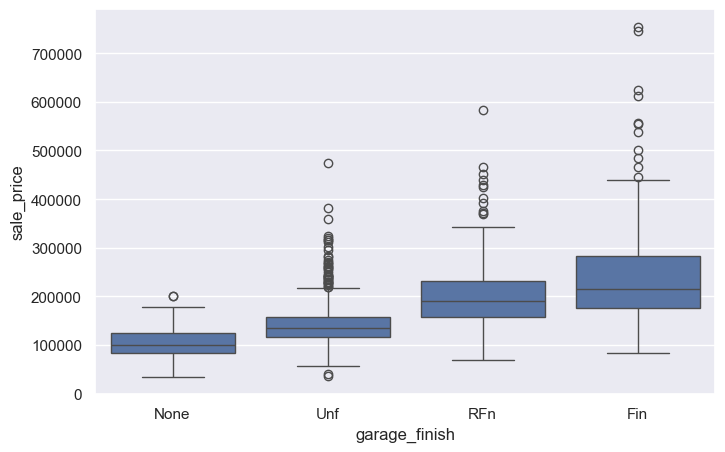

In [51]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="garage_finish", y="sale_price", order=["None", "Unf", "RFn", "Fin"])

In [52]:
df["garage_finish"] = df["garage_finish"].map(dict_garage_finish).astype("int8")

#### garage_qual and cond

In [53]:
train["garage_qual"] = train["garage_qual"].fillna("None")

train["garage_qual"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\979222345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["garage_qual"] = train["garage_qual"].fillna("None")


garage_qual
TA      1311
None      81
Fa        48
Gd        14
Ex         3
Po         3
Name: count, dtype: int64

<Axes: xlabel='garage_qual', ylabel='sale_price'>

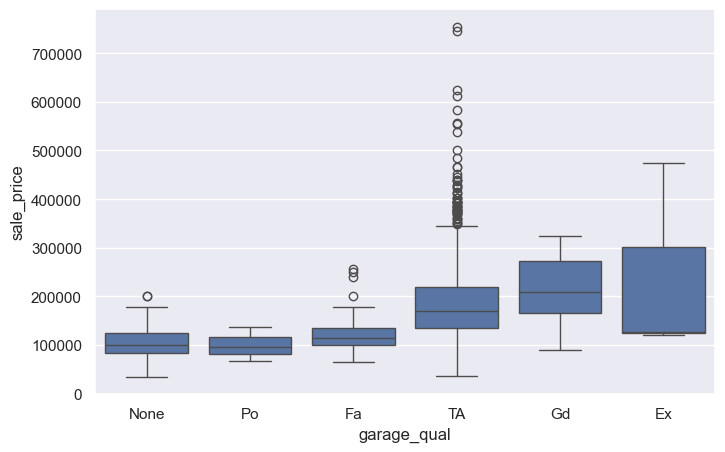

In [54]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="garage_qual", y="sale_price", order=["None", "Po", "Fa", "TA", "Gd", "Ex"])

In [55]:
df["garage_qual"] = df["garage_qual"].fillna("None")

df["garage_qual"] = df["garage_qual"].map(garage_qual_cond).astype("int8")

In [56]:
train["garage_cond"] = train["garage_cond"].fillna("None")

train["garage_cond"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\3021781408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["garage_cond"] = train["garage_cond"].fillna("None")


garage_cond
TA      1326
None      81
Fa        35
Gd         9
Po         7
Ex         2
Name: count, dtype: int64

<Axes: xlabel='garage_cond', ylabel='sale_price'>

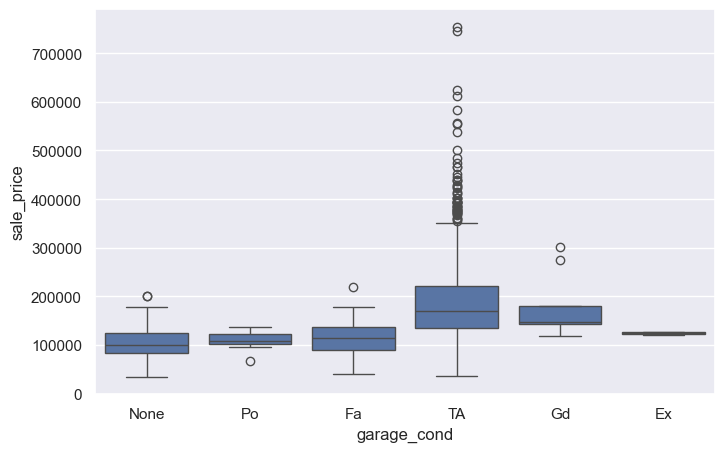

In [57]:
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="garage_cond", y="sale_price", order=["None", "Po", "Fa", "TA", "Gd", "Ex"])

In [58]:
df["garage_cond"] = df["garage_cond"].fillna("None")

df["garage_cond"] = df["garage_cond"].map(garage_qual_cond).astype("int8")

#### 확인

In [59]:
category2 = ["overall_qual","overall_cond","exter_qual","exter_cond","bsmt_qual",
             "bsmt_cond","bsmt_exposure","bsmt_fin_type",
             "heating_qc","electrical","kitchen_qual","fireplace_qual",
             "garage_finish","garage_qual","garage_cond", "is_fence", "is_functional", "is_pool"]

df[category2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall_qual    2919 non-null   int64 
 1   overall_cond    2919 non-null   int64 
 2   exter_qual      2919 non-null   int64 
 3   exter_cond      2919 non-null   int64 
 4   bsmt_qual       2919 non-null   int8  
 5   bsmt_cond       2919 non-null   int8  
 6   bsmt_exposure   2919 non-null   int8  
 7   bsmt_fin_type   2919 non-null   int64 
 8   heating_qc      2919 non-null   int8  
 9   electrical      2919 non-null   int8  
 10  kitchen_qual    2919 non-null   int8  
 11  fireplace_qual  2919 non-null   int8  
 12  garage_finish   2919 non-null   int8  
 13  garage_qual     2919 non-null   int8  
 14  garage_cond     2919 non-null   int8  
 15  is_fence        571 non-null    object
 16  is_functional   2919 non-null   int64 
 17  is_pool         2919 non-null   int64 
dtypes: int64

#### is_fence

In [60]:
df["is_fence"] = df["is_fence"].fillna("None")

df["is_fence"] = df["is_fence"].apply(lambda x : (0 if x == "None" else 1)).astype("int8")

df["is_fence"].value_counts()

is_fence
0    2348
1     571
Name: count, dtype: int64

In [61]:
category2 = ["overall_qual","overall_cond","exter_qual","exter_cond","bsmt_qual",
             "bsmt_cond","bsmt_exposure","bsmt_fin_type",
             "heating_qc","electrical","kitchen_qual","fireplace_qual",
             "garage_finish","garage_qual","garage_cond", "is_fence", "is_functional", "is_pool"]

df[category2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   overall_qual    2919 non-null   int64
 1   overall_cond    2919 non-null   int64
 2   exter_qual      2919 non-null   int64
 3   exter_cond      2919 non-null   int64
 4   bsmt_qual       2919 non-null   int8 
 5   bsmt_cond       2919 non-null   int8 
 6   bsmt_exposure   2919 non-null   int8 
 7   bsmt_fin_type   2919 non-null   int64
 8   heating_qc      2919 non-null   int8 
 9   electrical      2919 non-null   int8 
 10  kitchen_qual    2919 non-null   int8 
 11  fireplace_qual  2919 non-null   int8 
 12  garage_finish   2919 non-null   int8 
 13  garage_qual     2919 non-null   int8 
 14  garage_cond     2919 non-null   int8 
 15  is_fence        2919 non-null   int8 
 16  is_functional   2919 non-null   int64
 17  is_pool         2919 non-null   int64
dtypes: int64(7), int8(11)
memory

#### 순서형 변수 boxcox 실시



In [62]:
category2 = ["overall_qual","overall_cond","exter_qual","exter_cond","bsmt_qual",
             "bsmt_cond","bsmt_exposure","bsmt_fin_type",
             "heating_qc","electrical","kitchen_qual","fireplace_qual",
             "garage_finish","garage_qual","garage_cond"]

skew_features = df[category2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    # print(i)
    # print(i, features[i] + 1)
    # print(i, boxcox_normmax(features[i] + 1 , method="mle"))
    df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1, method="mle"))


### 명목형 데이터 처리

In [63]:
category1 = ["ms_subclass","ms_zoning","street_access","lot_shape", "alley",
             "land_contour","utilities","lot_config","land_slope","neighborhood",
             "bldg_type","house_style","roof_style",
             "roof_matl","mas_vnr_type","foundation",
             "heating","central_air","garage_type","paved_drive","misc_feature",
             "sale_type","sale_cond"]

In [64]:
df[category1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ms_subclass    2919 non-null   int64 
 1   ms_zoning      2919 non-null   object
 2   street_access  2919 non-null   object
 3   lot_shape      2919 non-null   object
 4   alley          198 non-null    object
 5   land_contour   2919 non-null   object
 6   utilities      2919 non-null   object
 7   lot_config     2919 non-null   object
 8   land_slope     2919 non-null   object
 9   neighborhood   2919 non-null   object
 10  bldg_type      2919 non-null   object
 11  house_style    2919 non-null   object
 12  roof_style     2919 non-null   object
 13  roof_matl      2919 non-null   object
 14  mas_vnr_type   1176 non-null   object
 15  foundation     2919 non-null   object
 16  heating        2919 non-null   object
 17  central_air    2919 non-null   object
 18  garage_type    2761 non-null

#### exterior_1st 2nd

In [65]:
no_equal_idx = df[df["exterior_1st"] != df["exterior_2nd"]].index

df = pd.get_dummies(df, columns=["exterior_1st"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 94 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2919 non-null   int64  
 1   ms_subclass           2919 non-null   int64  
 2   ms_zoning             2919 non-null   object 
 3   lot_frontage          2919 non-null   float64
 4   lot_area              2919 non-null   int64  
 5   street_access         2919 non-null   object 
 6   alley                 198 non-null    object 
 7   lot_shape             2919 non-null   object 
 8   land_contour          2919 non-null   object 
 9   utilities             2919 non-null   object 
 10  lot_config            2919 non-null   object 
 11  land_slope            2919 non-null   object 
 12  neighborhood          2919 non-null   object 
 13  condition1            2919 non-null   object 
 14  condition2            2919 non-null   object 
 15  bldg_type            

In [66]:
for idx in no_equal_idx:
    v = df.loc[idx, "exterior_2nd"]
    v = "exterior_1st_" + str(v)
    if v not in df.columns:
        arr = np.zeros(len(df)).astype("int8")
        arr[idx] = 1
        df[v] = arr
        df[v] = df[v].astype("bool")
    
    else:
        df.loc[idx, v] = 1
        df[v] = df[v].astype("bool")
        
df.drop(columns=["exterior_2nd"], inplace=True)


df.columns

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\907780365.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[idx, v] = 1
C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\907780365.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[idx, v] = 1
C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\907780365.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[idx, v] = 1
C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\907780365.py:11: FutureWarning: 

Index(['id', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street_access', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2',
       'bldg_type', 'house_style', 'overall_qual', 'overall_cond',
       'year_built', 'year_remod_add', 'roof_style', 'roof_matl',
       'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond',
       'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_sf1',
       'bsmt_fin_sf2', 'bsmt_un_sf', 'total_bsmt_sf', 'heating', 'heating_qc',
       'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf',
       'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
       'full_bath', 'half_bath', 'bedroom', 'kitchen', 'kitchen_qual',
       'tot_rms_abv_grd', 'fireplaces', 'fireplace_qual', 'garage_type',
       'garage_yr_built', 'garage_finish', 'garage_cars', 'garage_area',
       'garage_qual', 'garage_cond', 'paved_drive', 'wood_de

#### condition1 condition 2

In [67]:
no_equal_idx = df[df["condition1"] != df["condition2"]].index

df = pd.get_dummies(df, columns=["condition1"])

In [68]:
for idx in no_equal_idx:
    v = df.loc[idx, "condition2"]
    v = "condition1_" + str(v)
    if v not in df.columns:
        arr = np.zeros(len(df)).astype("int8")
        arr[idx] = 1
        df[v] = arr
        df[v] = df[v].astype("bool")
    
    else:
        df.loc[idx, v] = 1
        df[v] = df[v].astype("bool")
        
df.drop(columns=["condition2"], inplace=True)


df.columns

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\1697110462.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[idx, v] = 1
C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\1697110462.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[idx, v] = 1
C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\1697110462.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[idx, v] = 1
C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\1697110462.py:11: FutureWarni

Index(['id', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street_access', 'alley', 'lot_shape', 'land_contour', 'utilities',
       ...
       'exterior_1st_Other', 'condition1_Artery', 'condition1_Feedr',
       'condition1_Norm', 'condition1_PosA', 'condition1_PosN',
       'condition1_RRAe', 'condition1_RRAn', 'condition1_RRNe',
       'condition1_RRNn'],
      dtype='object', length=104)

#### dummies

In [69]:
df["ms_subclass"] = df["ms_subclass"].apply(str)

In [70]:
basic_ca1_cols = ["ms_subclass","ms_zoning","street_access","lot_shape", "alley",
             "land_contour","utilities","lot_config","land_slope","neighborhood",
             "bldg_type","house_style","roof_style",
             "roof_matl","foundation","mas_vnr_type", "garage_type", "misc_feature",
             "heating","central_air","paved_drive",
             "sale_type","sale_cond"]

df[basic_ca1_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ms_subclass    2919 non-null   object
 1   ms_zoning      2919 non-null   object
 2   street_access  2919 non-null   object
 3   lot_shape      2919 non-null   object
 4   alley          198 non-null    object
 5   land_contour   2919 non-null   object
 6   utilities      2919 non-null   object
 7   lot_config     2919 non-null   object
 8   land_slope     2919 non-null   object
 9   neighborhood   2919 non-null   object
 10  bldg_type      2919 non-null   object
 11  house_style    2919 non-null   object
 12  roof_style     2919 non-null   object
 13  roof_matl      2919 non-null   object
 14  foundation     2919 non-null   object
 15  mas_vnr_type   1176 non-null   object
 16  garage_type    2761 non-null   object
 17  misc_feature   106 non-null    object
 18  heating        2919 non-null

In [71]:
df = pd.get_dummies(df, columns=basic_ca1_cols)

len(df.columns)

221

### 연속형 데이터 처리

In [72]:
integer2 = ["lot_frontage","lot_area", "mas_vnr_area","total_bsmt_sf",
            "gr_liv_area","garage_area","wood_deck_sf","open_porch_sf",
            "enclosed_porch_sf","3ssn_porch_sf","screen_porch_sf", "misc_val"]

In [73]:
df["is_2f"] = df["2nd_flr_sf"].apply(lambda x : 1 if x > 0 else 0)

In [74]:
skew_features = df[integer2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1, method="mle"))

### 이산형 데이터 처리

In [75]:
integer1 = ["bsmt_full_bath","bsmt_half_bath","full_bath","half_bath","bedroom",
            "kitchen","tot_rms_abv_grd","garage_cars","fireplaces"]

#### bsmt bath

In [76]:
df["bsmt_full_bath"].describe()

count    2919.000000
mean        0.429599
std         0.524676
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: bsmt_full_bath, dtype: float64

In [77]:
df["bsmt_half_bath"].describe()

count    2919.000000
mean        0.061322
std         0.245608
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: bsmt_half_bath, dtype: float64

In [78]:
df["total_bsmt_bath"] = df["bsmt_full_bath"] + df["bsmt_half_bath"] * 0.5

df["total_bsmt_bath"].describe()

count    2919.000000
mean        0.460260
std         0.520778
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: total_bsmt_bath, dtype: float64

<Axes: xlabel='total_bsmt_bath', ylabel='sale_price'>

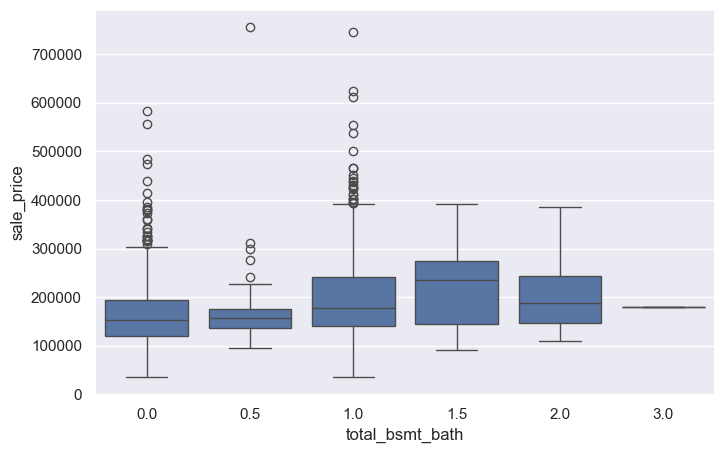

In [79]:
train["total_bsmt_bath"] = train["bsmt_full_bath"] + train["bsmt_half_bath"] * 0.5
sns.set(rc={"figure.figsize": (8, 5)})

sns.boxplot(data=train, x="total_bsmt_bath", y="sale_price")

<Axes: xlabel='is_bsmt_bath', ylabel='sale_price'>

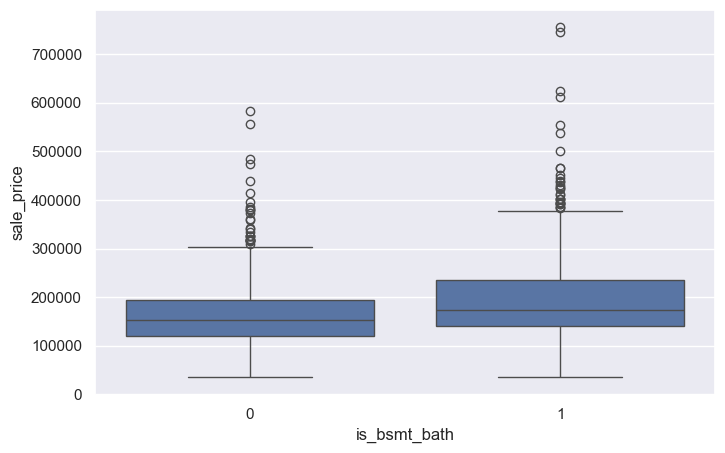

In [80]:
train["is_bsmt_bath"] = train["total_bsmt_bath"].apply(lambda x: 0 if x == 0 else 1)

sns.boxplot(data=train, x="is_bsmt_bath", y="sale_price")

In [81]:
df["is_bsmt_bath"] = df["total_bsmt_bath"].apply(lambda x: 0 if x == 0 else 1)

#### gr bath

In [82]:
train["full_bath"].describe()

count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: full_bath, dtype: float64

In [83]:
train["half_bath"].describe()

count    1460.000000
mean        0.382877
std         0.502885
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: half_bath, dtype: float64

In [84]:
train["total_bath"] = train["half_bath"] * 0.5 + train["full_bath"]

train["total_bath"].describe()

count    1460.000000
mean        1.756507
std         0.636015
min         0.000000
25%         1.000000
50%         2.000000
75%         2.500000
max         3.500000
Name: total_bath, dtype: float64

In [85]:
train["total_bath"].value_counts()

total_bath
1.0    469
2.0    433
2.5    334
1.5    180
3.0     20
3.5     18
0.5      3
0.0      3
Name: count, dtype: int64

<Axes: xlabel='total_bath', ylabel='sale_price'>

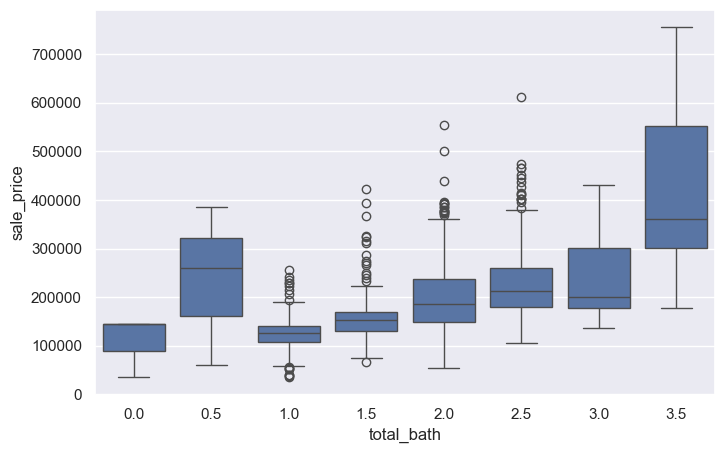

In [86]:
sns.boxplot(data=train, x="total_bath", y="sale_price")

In [87]:
df["total_bath"] = df["half_bath"] * 0.5 + df["full_bath"]
df["all_bath"] = df["total_bath"] + df["total_bsmt_bath"]

In [88]:
train["all_bath"] = train["total_bath"] + train["total_bsmt_bath"]

train["all_bath"].describe()

count    1460.000000
mean        2.210616
std         0.785399
min         1.000000
25%         2.000000
50%         2.000000
75%         2.500000
max         6.000000
Name: all_bath, dtype: float64

In [89]:
train["all_bath"].value_counts()

all_bath
2.0    456
2.5    295
1.0    228
3.0    186
3.5    144
1.5    129
4.0     13
4.5      7
6.0      1
5.0      1
Name: count, dtype: int64

<Axes: xlabel='all_bath', ylabel='sale_price'>

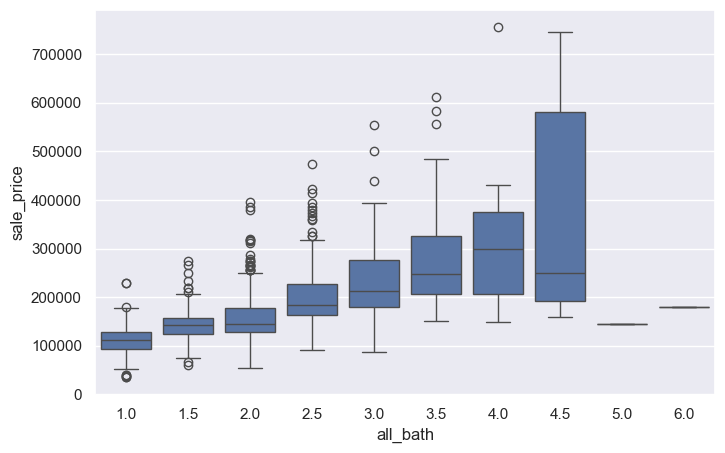

In [90]:
sns.boxplot(data=train, x="all_bath", y="sale_price")

#### bedroom

In [91]:
train["bedroom"].value_counts()

bedroom
3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: count, dtype: int64

<Axes: xlabel='bedroom'>

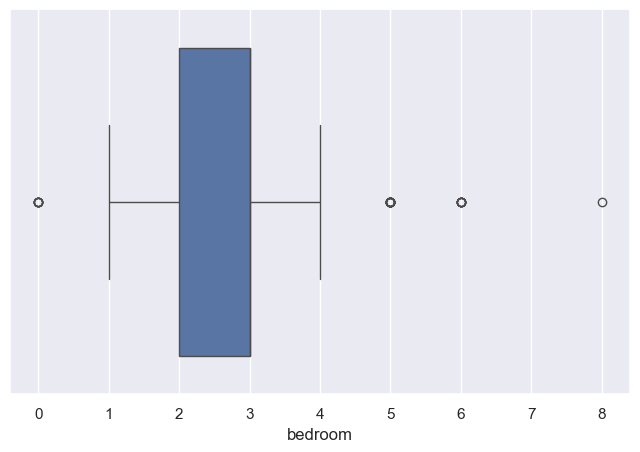

In [92]:
sns.boxplot(x=train["bedroom"])

<Axes: xlabel='bedroom', ylabel='sale_price'>

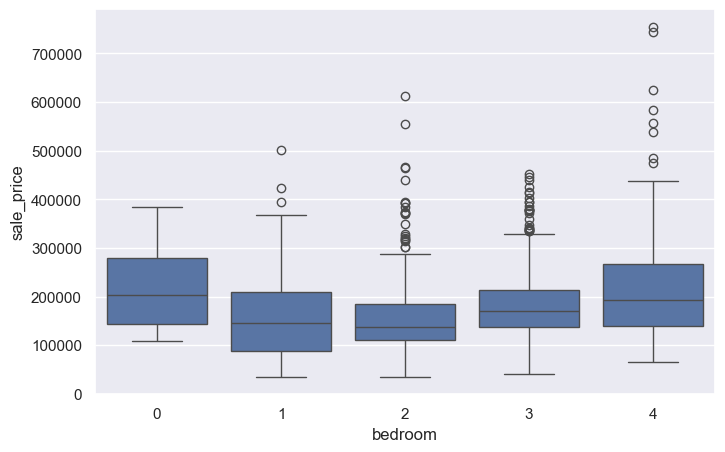

In [93]:
sns.boxplot(data=train[train["bedroom"] < 5], x="bedroom", y="sale_price")

#### kitchen

In [94]:
train["kitchen"].describe()

count    1460.00000
mean        1.04726
std         0.21863
min         1.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         3.00000
Name: kitchen, dtype: float64

In [95]:
train["kitchen"].value_counts()

kitchen
1    1393
2      65
3       2
Name: count, dtype: int64

<Axes: xlabel='kitchen', ylabel='sale_price'>

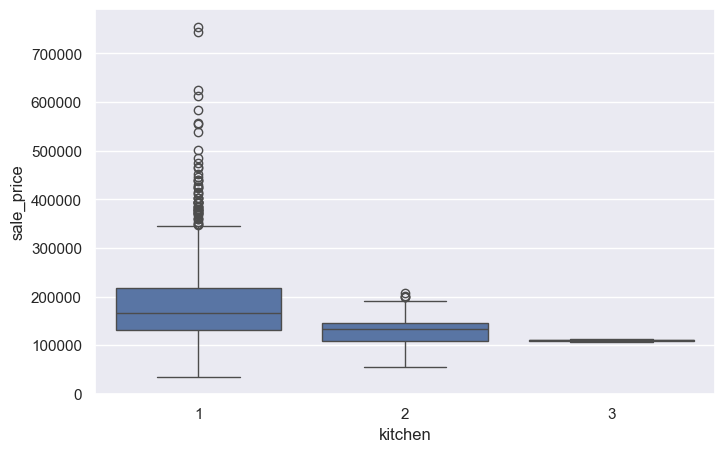

In [96]:
sns.boxplot(data=train, x="kitchen", y="sale_price")

In [97]:
# kitchen drop

df = df.drop(columns=["kitchen"])

#### tot_rms_abv_grd

In [98]:
train["tot_rms_abv_grd"].describe()

count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: tot_rms_abv_grd, dtype: float64

In [99]:
train["tot_rms_abv_grd"].value_counts()

tot_rms_abv_grd
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: count, dtype: int64

<Axes: xlabel='tot_rms_abv_grd'>

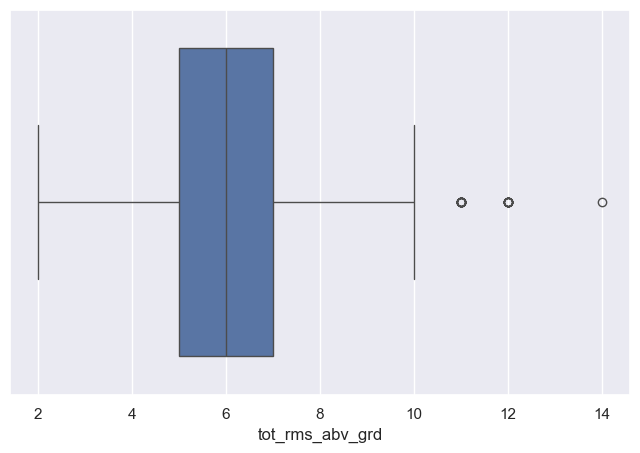

In [100]:
sns.boxplot(x=train["tot_rms_abv_grd"])

<Axes: xlabel='tot_rms_abv_grd', ylabel='sale_price'>

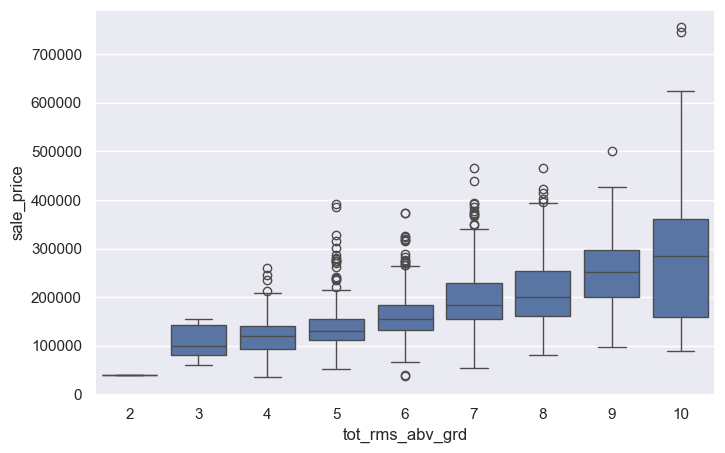

In [101]:
sns.boxplot(data=train[train["tot_rms_abv_grd"] <= 10], x="tot_rms_abv_grd", y="sale_price")

In [102]:
df[df["tot_rms_abv_grd"] > 10]

,id,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,exter_qual,exter_cond,...,sale_cond_AdjLand,sale_cond_Alloca,sale_cond_Family,sale_cond_Normal,sale_cond_Partial,is_2f,total_bsmt_bath,is_bsmt_bath,total_bath,all_bath
11,12,21.380823,18.363180,9,3.009505,2005,2006,3.040935,0.930679,1.266928,...,False,False,False,False,True,1,1.0,1,3.0,4.0
118,119,22.155834,18.489460,7,3.009505,1990,1990,0.000000,0.746120,1.266928,...,False,False,False,True,False,1,1.0,1,3.0,4.0
185,186,22.155834,20.677235,10,4.545485,1892,1993,0.000000,0.858733,1.450071,...,False,False,False,True,False,1,0.0,0,2.5,2.5
324,325,23.062839,18.174375,7,3.822553,1967,2007,3.052565,0.858733,1.450071,...,False,False,False,True,False,1,0.0,0,2.5,2.5
523,524,27.816278,22.810496,10,3.009505,2007,2008,3.254186,0.930679,1.266928,...,False,False,False,False,True,1,1.0,1,3.5,4.5
527,528,18.420745,19.139830,9,3.009505,2008,2008,3.024898,0.930679,1.266928,...,False,False,False,False,True,1,1.0,1,2.5,3.5
566,567,20.100635,18.151351,9,3.009505,2005,2007,3.002340,0.858733,1.266928,...,False,False,False,True,False,1,0.0,0,2.5,2.5
635,636,17.182909,18.059698,6,3.822553,1914,1995,0.000000,0.539424,1.266928,...,False,False,False,False,False,1,0.0,0,2.0,2.0
745,746,20.793409,17.414398,8,4.545485,1976,1996,3.043486,0.930679,1.450071,...,False,False,False,True,False,1,0.5,1,3.5,4.0
769,770,14.714487,23.975937,8,3.009505,2003,2003,3.207821,0.930679,1.266928,...,False,False,False,True,False,1,1.0,1,3.5,4.5


#### garage_cars

In [103]:
train["garage_cars"].describe()

count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: garage_cars, dtype: float64

<Axes: xlabel='garage_cars'>

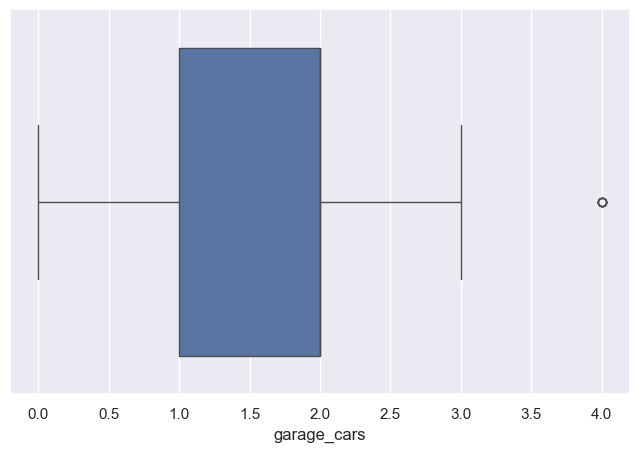

In [104]:
sns.boxplot(x = train["garage_cars"])

<Axes: xlabel='garage_cars', ylabel='sale_price'>

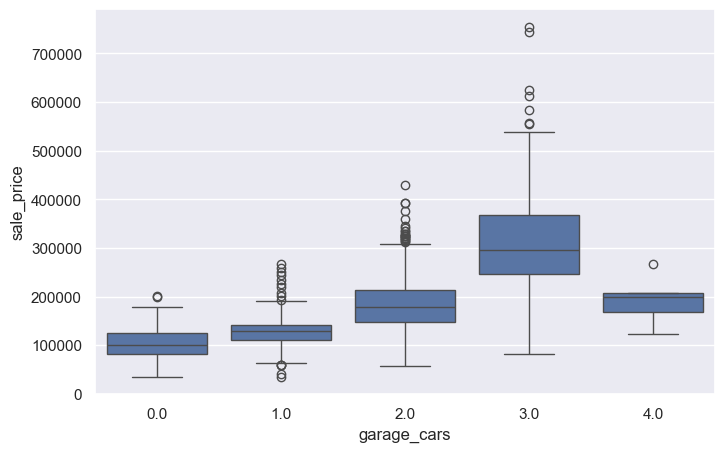

In [105]:
sns.boxplot(data = train, x = "garage_cars", y="sale_price")

#### fireplaces

In [106]:
train["fireplaces"].describe()

count    1460.000000
mean        0.613014
std         0.644666
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: fireplaces, dtype: float64

In [107]:
train["fireplaces"].value_counts()

fireplaces
0    690
1    650
2    115
3      5
Name: count, dtype: int64

<Axes: xlabel='fireplaces', ylabel='sale_price'>

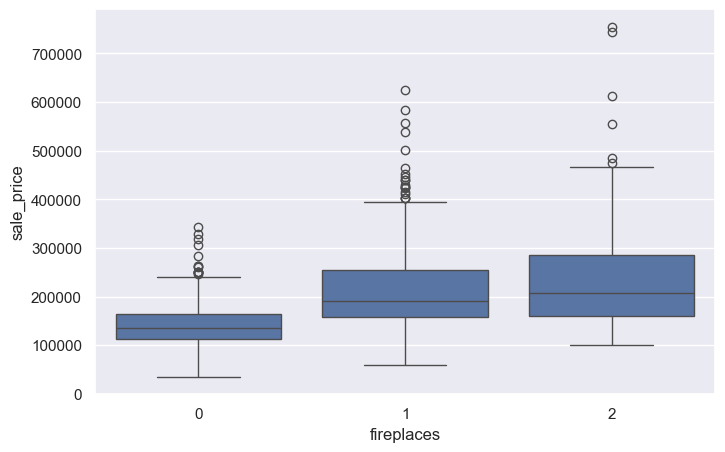

In [108]:
sns.boxplot(data = train[train["fireplaces"] < 3], x = "fireplaces", y="sale_price")

#### 이산형 box cox 적용

In [109]:
# integer1 = ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom', 
#             'tot_rms_abv_grd', 'garage_cars', 'fireplaces','total_bsmt_bath',
#             "all_bath", "total_bath"]

# skew_features = df[integer1].apply(lambda x: skew(x)).sort_values(ascending=False)

# high_skew = skew_features[skew_features > 0.5]
# skew_index = high_skew.index

# skew_index


In [110]:

# for i in skew_index:
#     df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1, method="mle"))


### 시계열 데이터 처리

In [111]:
time_data = ["year_built", "year_remod_add", "garage_yr_built", "mo_sold", "yr_sold"]

In [112]:
time_df = train[time_data + ["sale_price", "neighborhood"]]

idx = time_df[time_df["year_built"] == time_df["year_remod_add"]].index

time_df["is_remod"] = [1] * len(time_df)

time_df.loc[idx, "is_remod"] = 0

time_df["is_remod"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\3913275046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df["is_remod"] = [1] * len(time_df)


is_remod
0    764
1    696
Name: count, dtype: int64

<Axes: xlabel='neighborhood', ylabel='sale_price'>

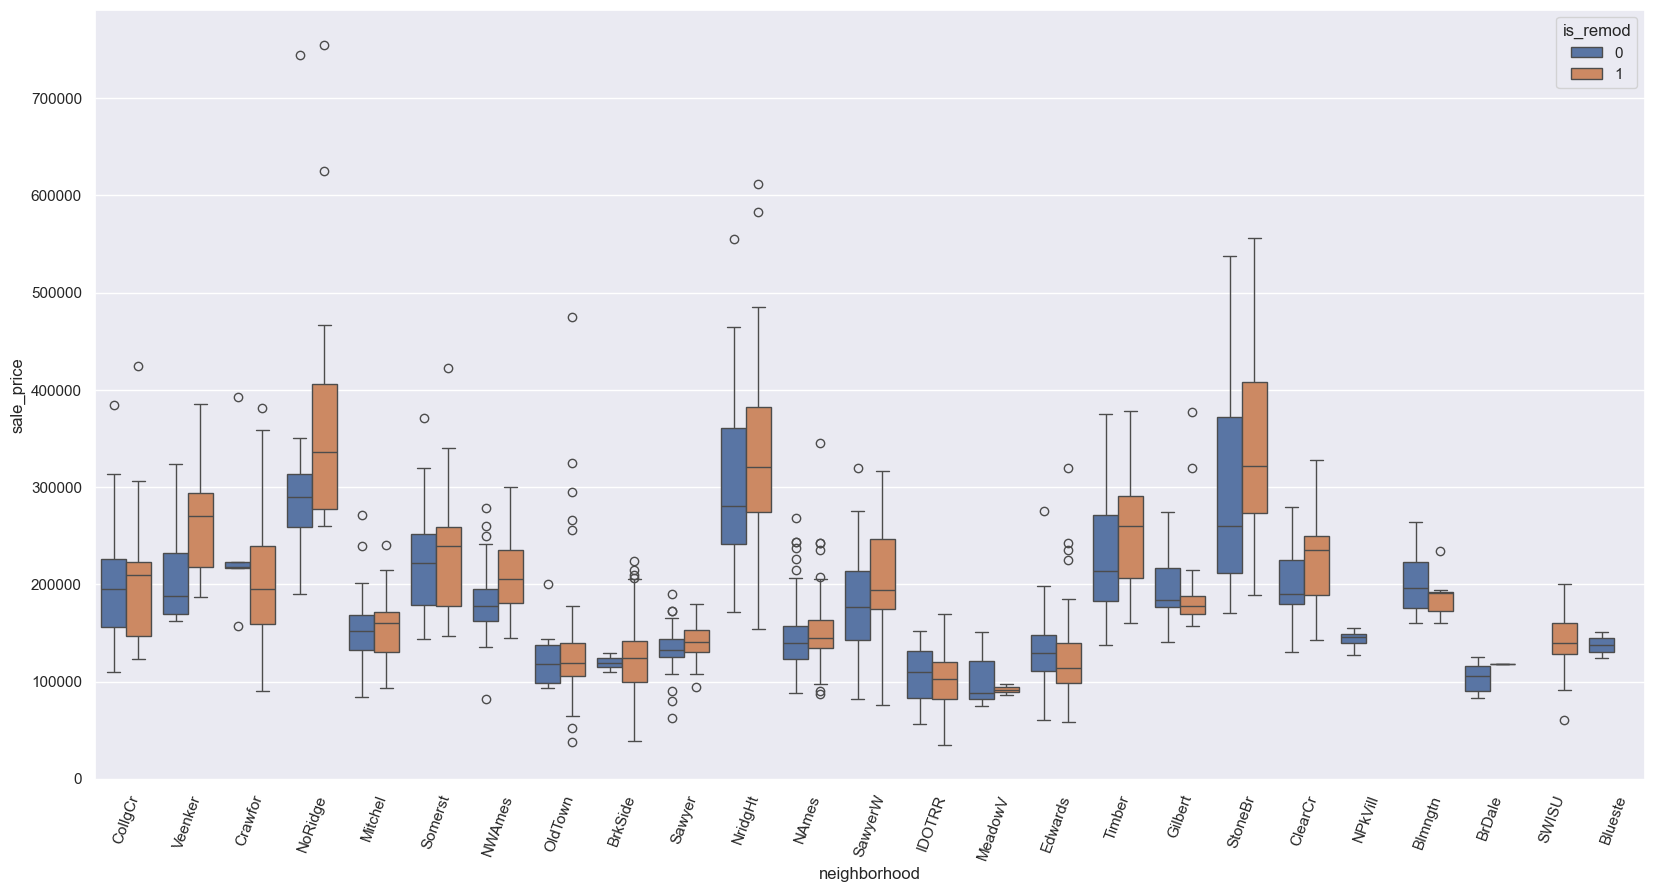

In [113]:
sns.set(rc={"figure.figsize": (20, 10)})

fig = sns.boxplot(data=time_df, x="neighborhood", y="sale_price", hue="is_remod")

fig.tick_params(axis='x', rotation=70)

fig

In [114]:
time_df["diff_built_sold"] = time_df["yr_sold"] - time_df["year_built"]
time_df["diff_remod_sold"] = time_df["yr_sold"] - time_df["year_remod_add"]

C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\1051847924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df["diff_built_sold"] = time_df["yr_sold"] - time_df["year_built"]
C:\Users\kkj98\AppData\Local\Temp\ipykernel_11648\1051847924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df["diff_remod_sold"] = time_df["yr_sold"] - time_df["year_remod_add"]


In [115]:
time_df["diff_built_sold"].describe()

count    1460.000000
mean       36.547945
std        30.250152
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: diff_built_sold, dtype: float64

<Axes: xlabel='diff_built_sold'>

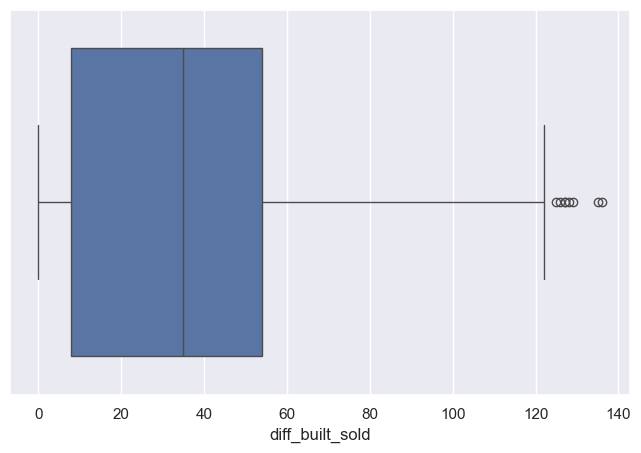

In [116]:
sns.set(rc={"figure.figsize": (8, 5)})
sns.boxplot(x=time_df["diff_built_sold"])

<Axes: xlabel='diff_built_sold', ylabel='sale_price'>

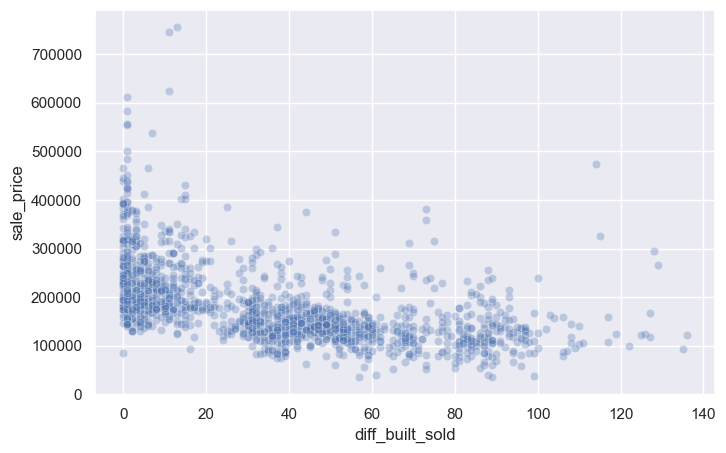

In [117]:
sns.set(rc={"figure.figsize": (8, 5)})
sns.scatterplot(data=time_df, x="diff_built_sold", y="sale_price", alpha=0.3)

<Axes: xlabel='diff_built_sold', ylabel='sale_price'>

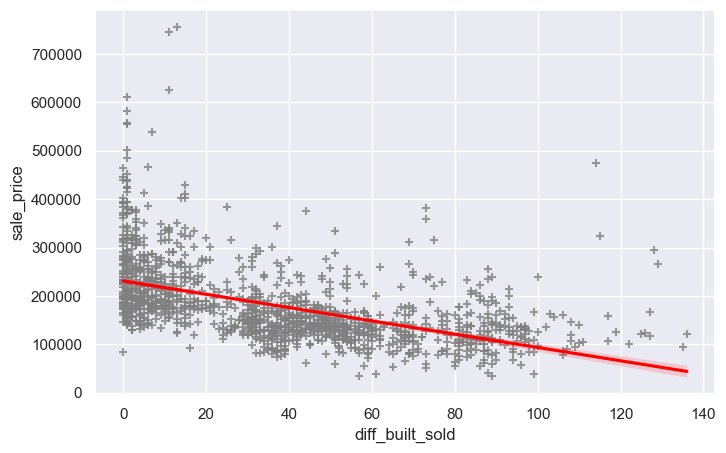

In [118]:
sns.set(rc={"figure.figsize": (8, 5)})
sns.regplot(data=time_df, 
            x="diff_built_sold", 
            y="sale_price",
            marker="+",
            line_kws={'color': 'red'}, 
            scatter_kws={'color': 'grey'}
            )

In [119]:
time_df["diff_remod_sold"].describe()

count    1460.000000
mean       22.950000
std        20.640653
min        -1.000000
25%         4.000000
50%        14.000000
75%        41.000000
max        60.000000
Name: diff_remod_sold, dtype: float64

In [120]:
time_df[time_df["year_remod_add"] > time_df["yr_sold"]]

,year_built,year_remod_add,garage_yr_built,mo_sold,yr_sold,sale_price,neighborhood,is_remod,diff_built_sold,diff_remod_sold
523,2007,2008,2007.0,10,2007,184750.0,Edwards,1,0,-1


<Axes: xlabel='diff_remod_sold'>

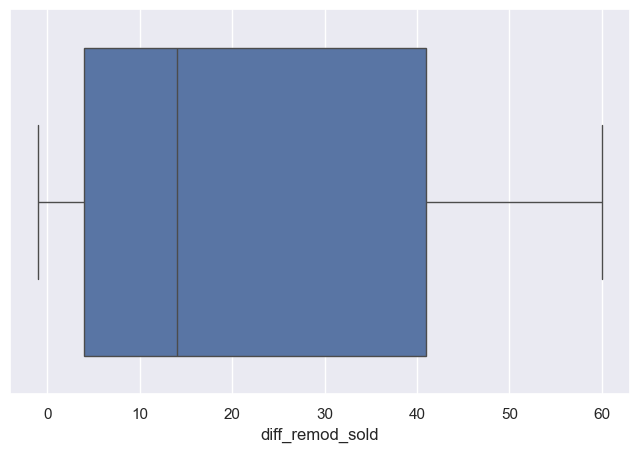

In [121]:
sns.set(rc={"figure.figsize": (8, 5)})
sns.boxplot(x=time_df["diff_remod_sold"])

<Axes: xlabel='diff_remod_sold', ylabel='sale_price'>

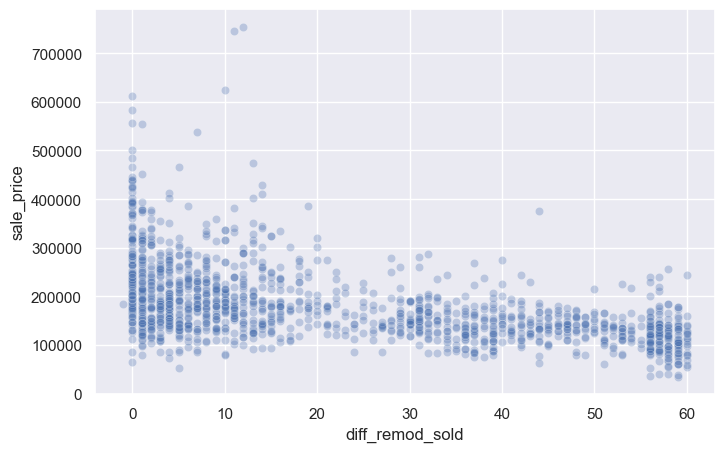

In [122]:
sns.set(rc={"figure.figsize": (8, 5)})
sns.scatterplot(data=time_df, x="diff_remod_sold", y="sale_price", alpha=0.3)

<Axes: xlabel='diff_remod_sold', ylabel='sale_price'>

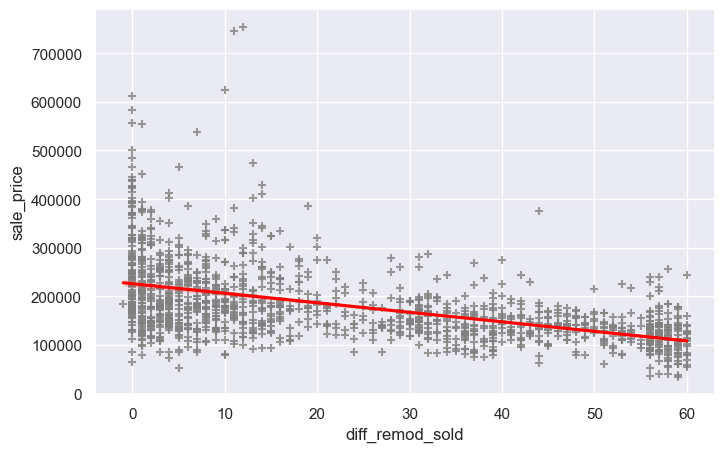

In [123]:
sns.set(rc={"figure.figsize": (8, 5)})
sns.regplot(data=time_df, 
            x="diff_remod_sold", 
            y="sale_price",
            marker="+",
            line_kws={'color': 'red'}, 
            scatter_kws={'color': 'grey'}
            )

In [124]:
time_df["mo_sold"].value_counts()

mo_sold
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: count, dtype: int64

<Axes: xlabel='mo_sold', ylabel='sale_price'>

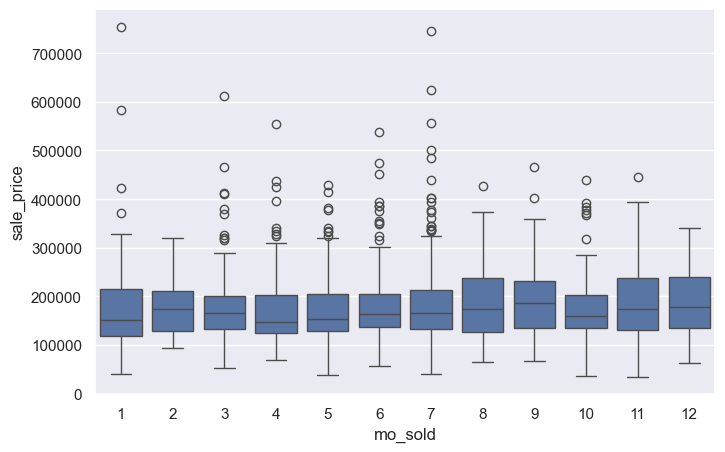

In [125]:
sns.boxplot(data=time_df, x="mo_sold", y="sale_price")

In [126]:
# remodeling 여부

idx = df[df["year_built"] == df["year_remod_add"]].index

df["is_remod"] = [1] * len(df)

df.loc[idx, "is_remod"] = 0

In [127]:
# 판매된 달에 대한 원핫인코딩

df["mo_sold"] = df["mo_sold"].apply(str)

df = pd.get_dummies(df, columns = ["mo_sold"])

In [128]:
df["diff_built_so"] = df["yr_sold"] - df["year_built"]
df["diff_remod_so"] = df["yr_sold"] - df["year_remod_add"]

In [ ]:
train = df[df["sale_price"].isna() == False]


<Axes: xlabel='garage_yr_built', ylabel='sale_price'>

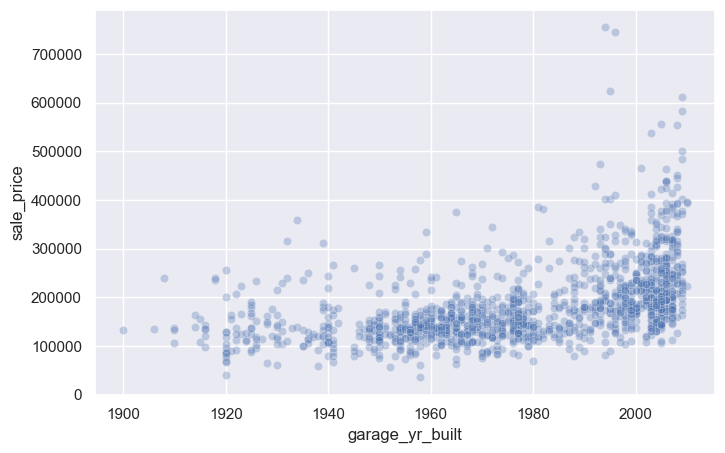

In [132]:
data = train[["garage_yr_built", "sale_price"]]
grb = "garage_yr_built"

sns.scatterplot(data=data, x=grb, y="sale_price", alpha=0.3)

<Axes: ylabel='sale_price'>

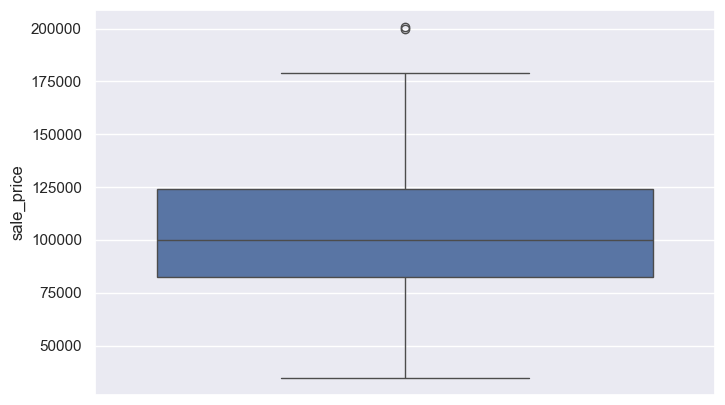

In [135]:
sns.boxplot(y=data[data[grb].isna()]["sale_price"])

<Axes: ylabel='garage_yr_built'>

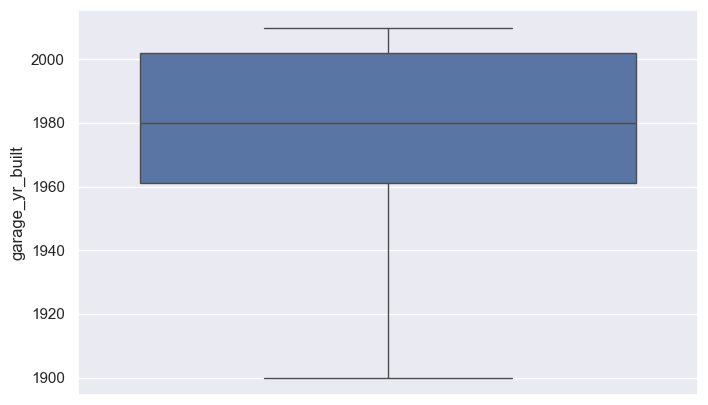

In [136]:
sns.boxplot(y=data[grb])

In [947]:
# garage_yr_built


gyb = "garage_yr_built"

df[gyb].describe()

idx = df[df[gyb].isna()].index

df.loc[idx, gyb] = 1979



In [948]:
df["diff_gyb_so"] = df["yr_sold"] - df["garage_yr_built"]
df.drop(columns=["yr_sold", "year_built", "year_remod_add", "garage_yr_built"], inplace=True)

In [949]:
time_cols = ["diff_gyb_so","diff_built_so","diff_remod_so", "year_built_v1"]

df[time_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   diff_gyb_so    2919 non-null   float64
 1   diff_built_so  2919 non-null   int64  
 2   diff_remod_so  2919 non-null   int64  
 3   year_built_v1  2919 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 91.3 KB


In [950]:
df[df["diff_built_so"]  < 0]

,id,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,...,mo_sold_3,mo_sold_4,mo_sold_5,mo_sold_6,mo_sold_7,mo_sold_8,mo_sold_9,diff_built_so,diff_remod_so,diff_gyb_so
2549,2550,27.552104,22.730307,10,3.009505,3.34027,0.930679,1.266927,3,2,...,False,False,False,False,False,False,False,-1,-2,-1.0


In [951]:
skew_features = df[time_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1, method="mle"))

/home/gijeong/miniconda3/envs/hhp/lib/python3.8/site-packages/scipy/stats/_morestats.py:924: RuntimeWarning: divide by zero encountered in log
  logdata = np.log(data)
/home/gijeong/miniconda3/envs/hhp/lib/python3.8/site-packages/scipy/stats/_morestats.py:933: RuntimeWarning: divide by zero encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/gijeong/miniconda3/envs/hhp/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/gijeong/miniconda3/envs/hhp/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2416: RuntimeWarning: invalid value encountered in scalar subtract
  tmp1 = (x - w) * (fx - fv)
/home/gijeong/miniconda3/envs/hhp/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in scalar subtract
  tmp2 = (x - v) * (fx - fw)


## 저장

In [952]:
cols = df.columns

In [953]:
for i in range(len(cols)//10 + 1):
    print(df[cols[(i-1)*10:i*10]].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Empty DataFrame
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2919 non-null   int64  
 1   lot_frontage  2919 non-null   float64
 2   lot_area      2919 non-null   float64
 3   overall_qual  2919 non-null   int64  
 4   overall_cond  2919 non-null   float64
 5   mas_vnr_area  2919 non-null   float64
 6   exter_qual    2919 non-null   float64
 7   exter_cond    2919 non-null   float64
 8   bsmt_qual     2919 non-null   int8   
 9   bsmt_cond     2919 non-null   int8   
dtypes: float64(6), int64(2), int8(2)
memory usage: 188.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bsmt_exposur

In [954]:
df["exterior_1st_HdBoard"].value_counts()

exterior_1st_HdBoard
False    2454
True      465
Name: count, dtype: int64

In [955]:
df.to_csv(os.path.join(data_path, "feature_v8.csv"), index=False)